In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"


In [3]:
from datasets import load_dataset

dataset = load_dataset("searle-j/kote")
#print(dataset)


No config specified, defaulting to: kote/dichotomized
Found cached dataset kote (/home/kjhkjh95/.cache/huggingface/datasets/searle-j___kote/dichotomized/0.0.0/9e18d6e4c5fb5b54c412810da99dfa5e5ece83c40924ee5eb3f41ce5b4d5b436)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
import numpy as np

from tqdm.notebook import tqdm

import torch ## version >= 1.8.2
import torch.nn as nn

import pytorch_lightning as pl ## version == 1.4.9

import datasets ## version == 2.1.0

from transformers import AutoTokenizer, AutoModel ## version == 4.12.3

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


In [6]:
try:
    import transformers, emoji, soynlp, pytorch_lightning
except:
    !pip install -U -q transformers emoji soynlp pytorch-lightning

In [7]:
import emoji
from soynlp.normalizer import repeat_normalize
import re

In [8]:
import os
import pandas as pd

from pprint import pprint

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from pytorch_lightning import LightningModule, Trainer, seed_everything

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize

In [9]:
train = dataset['train']
validation = dataset['validation']
test = dataset['test']

In [10]:
type(train)

datasets.arrow_dataset.Dataset

In [11]:
import pandas as pd

In [12]:
df_train=pd.DataFrame(train)
df_val=pd.DataFrame(validation)
df_test=pd.DataFrame(test)

In [13]:
#논문에 있는 영어로 매칭 
LABELS = ['불평/불만', #dissatisfaction,
 '환영/호의', # welcome,
 '감동/감탄', # admiration,
 '지긋지긋', #fed up,
 '고마움', #gratitude,
 '슬픔', #sadness,
 '화남/분노', #anger,
 '존경', #respect,
 '기대감', #expectancy,
 '우쭐댐/무시함', #arrogance,
 '안타까움/실망', #disappointment,
 '비장함', #resolute,
 '의심/불신', #distrust,
 '뿌듯함', #pride,
 '편안/쾌적', #comfort,
 '신기함/관심', #interest,
 '아껴주는', # care,
 '부끄러움', #shame,
 '공포/무서움', #fear,
 '절망', #despair,
 '한심함', #pathetic,
 '역겨움/징그러움', #disgust,
 '짜증', #irritation,
 '어이없음', #preposterous,
 '없음', #No Emotion,
 '패배/자기혐오', #gessepany,
 '귀찮음', #laziness,
 '힘듦/지침', #exhaustion,
 '즐거움/신남', #excitement,
 '깨달음', #realization,
 '죄책감', #guilt,
 '증오/혐오', #contempt,
 '흐뭇함(귀여움/예쁨)', #attracted,
 '당황/난처', #embarrassment,
 '경악', #shock,
 '부담/안_내킴', #reluctant,
 '서러움',#sorrow, 
 '재미없음', #boredom,
 '불쌍함/연민', #compassion,
 '놀람', #surprise,
 '행복', #happiness,
 '불안/걱정', #anxiety,
 '기쁨', #joy,
 '안심/신뢰'] #relief,

In [14]:
en_LABELS = ['dissatisfaction',
 'welcome',
 'admiration',
 'fed up',
 'gratitude',
 'sadness',
 'anger',
 'respect',
 'expectancy',
 'arrogance',
 'disappointment',
 'resolute',
 'distrust',
 'pride',
 'comfort',
 'interest',
 'care',
 'shame',
 'fear',
 'despair',
 'pathetic',
 'disgust',
 'irritation',
 'preposterous',
 'no emotion',
 'gessepany',
 'laziness',
 'exhaustion',
 'excitement',
 'realization',
 'guilt',
 'contempt',
 'attracted',
 'embarrassment',
 'shock',
 'reluctant',
 'sorrow', 
 'boredom',
 'compassion',
 'surprise',
 'happiness',
 'anxiety',
 'joy',
 'relief']

In [15]:
label_set =set(en_LABELS)

## 현재 분류 기준
- 1. https://psycnet.apa.org/record/2009-07773-044 Haidit의  연구에서 사용한 분류를 따른다.
(https://pages.stern.nyu.edu/~jhaidt/articles/alternate_versions/haidt.2003.the-moral-emotions.pub025-as-html.html)

   - Other-Condemming : 'disgust',"contempt",'anger'
   - Self-Conscious: 'shame', 'guilt', 'embarrasment' 
   - Other-Suffering : 'compassion'
   - Other-Praising : "gratitude, admiration" 
   

In [16]:
emotions_dic = {
    'Other-Condemming': ['disgust',"contempt",'anger'],
    'Self-Conscious': ['embarrassment', 'shame', 'guilt'],
    'Other-Suffering': ['compassion'],
    'Other-Praising': ['admiration', "gratitude",'respect'],
    }
    

In [17]:
other_c = set(emotions_dic['Other-Condemming'])
self_c = set(emotions_dic['Self-Conscious'])
other_s = set(emotions_dic['Other-Suffering'])
other_p = set(emotions_dic['Other-Praising'])
#self_e_p = set(emotions_dic['Self-Evaluate-Positive'])

In [18]:
non_moral_emotion = label_set.difference(other_c, self_c, other_s, other_p)
non_moral_emotion = list(non_moral_emotion)

In [19]:
emotions_dic = {
    'Other-Condemming': ['disgust',"contempt",'anger'],
    'Self-Conscious': ['embarrassment', 'shame', 'guilt'],
    'Other-Suffering': ['compassion'],
    'Other-Praising': ['admiration', "gratitude",'respect'],
    'Non-Moral-Emotion': non_moral_emotion
    }

In [20]:
emotions_detail_dic = {
    'disgust': 'disgust',
    "contempt": "contempt",
    "anger": "anger",
    "compassion" : 'compassion',
    'admiration':'admiration',
    "gratitude": "gratitude",
    'embarrassment':'embarrassment',
    "shame": 'shame',
    "guilt": 'guilt',
    'respect': 'respect',
    "Non-Moral-Emotion": non_moral_emotion
    }

In [21]:
len(emotions_detail_dic)

11

In [22]:
df_train=pd.DataFrame(train)
df_val=pd.DataFrame(validation)
df_test=pd.DataFrame(test)

In [23]:
df_train['labels'] = df_train['labels'].map(lambda x: [en_LABELS[i] for i in x])
df_val['labels'] = df_val['labels'].map(lambda x: [en_LABELS[i] for i in x])
df_test['labels'] = df_test['labels'].map(lambda x: [en_LABELS[i] for i in x])

In [24]:
df_train['labels']

0        [admiration, pride, interest, care, realizatio...
1        [dissatisfaction, sadness, respect, disappoint...
2                           [welcome, admiration, respect]
3        [arrogance, interest, pathetic, preposterous, ...
4        [welcome, admiration, expectancy, arrogance, r...
                               ...                        
39995    [welcome, admiration, gratitude, respect, expe...
39996                 [interest, care, attracted, anxiety]
39997    [welcome, respect, expectancy, pride, care, no...
39998    [admiration, arrogance, disappointment, intere...
39999    [arrogance, interest, pathetic, preposterous, ...
Name: labels, Length: 40000, dtype: object

### Moral Emotion Mapping

In [25]:

def map_emotion_multi(labels):
    matched_emotions = []
    for emotion, emo_labels in emotions_dic.items():
        for label in labels:
            if label in emo_labels:
                matched_emotions.append(emotion)
    temp = list(set(matched_emotions))
    return temp

def map_emotion_detail_multi(labels):
    matched_emotions = []
    for emotion, emo_labels in emotions_detail_dic.items():
        for label in labels:
            if label in emo_labels:
                matched_emotions.append(emotion)
    temp = list(set(matched_emotions))
    return temp


df_train["moral_emotion"] = df_train["labels"].apply(map_emotion_multi)
df_val["moral_emotion"] = df_val["labels"].apply(map_emotion_multi)
df_test["moral_emotion"] = df_test["labels"].apply(map_emotion_multi)
df_train["moral_emotion_detail"] = df_train["labels"].apply(map_emotion_detail_multi)
df_val["moral_emotion_detail"] = df_val["labels"].apply(map_emotion_detail_multi)
df_test["moral_emotion_detail"] = df_test["labels"].apply(map_emotion_detail_multi)

df_test

,ID,text,labels,moral_emotion,moral_emotion_detail
0,2012,개인적으로 원빈이 더 늙기전에 데이빗(톰크루즈) 역활로 한국판 리메이크 개봉 했으면...,[expectancy],[Non-Moral-Emotion],[Non-Moral-Emotion]
1,14463,미니돈까스ㅠㅠㅠ한번 먹으면 계속 손감,"[admiration, sadness, expectancy, distrust, sh...","[Self-Conscious, Non-Moral-Emotion, Other-Prai...","[guilt, Non-Moral-Emotion, shame, embarrassmen..."
2,41135,혹시 연기해보실 맘 없시유? 부인보다 잘할것 갔유 ㅋㅋㅋ!,"[welcome, admiration, gratitude, expectancy, a...","[Non-Moral-Emotion, Other-Praising]","[admiration, gratitude, Non-Moral-Emotion]"
3,38269,저건 양아치를 넘어서 걍 날강도 수준인데,"[dissatisfaction, anger, disappointment, distr...","[Self-Conscious, Other-Condemming, Non-Moral-E...","[contempt, anger, embarrassment, Non-Moral-Emo..."
4,21070,고장나서 왔는데 as 받기 힘들어요. 스피커 이어폰 꽂는 잭이 이미 고장난채로 와서...,"[dissatisfaction, anger, disappointment, irrit...","[Self-Conscious, Other-Condemming, Non-Moral-E...","[anger, embarrassment, Non-Moral-Emotion]"
...,...,...,...,...,...
4995,6161,일단 내용만 보고놓자면 크게 신경쓸일은 아닌거같네요 한국룸메랑 같이 비교하지마세요 ...,"[dissatisfaction, comfort, care, pathetic, no ...","[Other-Suffering, Non-Moral-Emotion]","[compassion, Non-Moral-Emotion]"
4996,21130,캐릭터가 프린트된 제품인줄 알았는데 스티커임 손으로 조물조물 빨았는데 캐릭터들이 쪼...,"[dissatisfaction, anger, disappointment, distr...","[Self-Conscious, Other-Condemming, Non-Moral-E...","[anger, embarrassment, Non-Moral-Emotion]"
4997,6788,마지막에 마카롱으로 미키마우스만든거 넘귀엽다ㅋ,"[welcome, admiration, interest, care, exciteme...","[Non-Moral-Emotion, Other-Praising]","[admiration, Non-Moral-Emotion]"
4998,45946,너무 멋진 친구를 두셨네요 작가님 함께 같이 살아갑시다,"[welcome, admiration, care, joy, relief]","[Non-Moral-Emotion, Other-Praising]","[admiration, Non-Moral-Emotion]"


In [26]:
df_val.tail(30)

,ID,text,labels,moral_emotion,moral_emotion_detail
4970,29307,그러니까 그게 서울시장 보궐선거와 무슨 상관인데??,"[dissatisfaction, fed up, anger, distrust, pat...","[Other-Condemming, Non-Moral-Emotion]","[anger, Non-Moral-Emotion]"
4971,20339,신생아 모자인데 박음질이 까슬하지 않을까 걱정되네요. 세탁택도 박음질에 말려 같이 ...,"[dissatisfaction, anger, disappointment, distr...","[Self-Conscious, Other-Condemming, Non-Moral-E...","[anger, embarrassment, Non-Moral-Emotion]"
4972,28856,다른 운전자도 마찬가지지만 대형트럭기사들 잠 좀 푹 자고 운전대 잡으시길! 니들 잠...,"[dissatisfaction, anger, fear, pathetic, irrit...","[Self-Conscious, Other-Condemming, Non-Moral-E...","[anger, embarrassment, Non-Moral-Emotion]"
4973,28627,실거주자까지 피해를 주니 문제다 이러다 사회주의 공산주의 되겠다 똑같이 나눠먹기식 ...,"[dissatisfaction, anger, disappointment, distr...","[Other-Condemming, Non-Moral-Emotion]","[contempt, anger, Non-Moral-Emotion]"
4974,304,대표는 뜬금없이 나와서 바람둥이 같이 표현하고 현우 친구들은 대체 착한놈들인지 나쁜...,"[dissatisfaction, anger, disappointment, distr...","[Self-Conscious, Other-Condemming, Non-Moral-E...","[contempt, anger, embarrassment, Non-Moral-Emo..."
4975,10783,마자요 연비가 올라가니 차가 막혀도 여유가 생겨요님도 빗길 안전운전 하셔요,"[expectancy, pride, comfort, interest, care, e...",[Non-Moral-Emotion],[Non-Moral-Emotion]
4976,21690,상품 판매시 사은품 주는 거처럼 판매하지 않으셨음 합니다 옵션에 따라 판매한다고 하...,"[dissatisfaction, anger, disappointment, pathe...","[Other-Condemming, Non-Moral-Emotion]","[anger, Non-Moral-Emotion]"
4977,928,어떠한 말로도 표현이 안된다. 영상 연기 음악 최고다,"[admiration, respect, joy]","[Non-Moral-Emotion, Other-Praising]","[admiration, Non-Moral-Emotion, respect]"
4978,9367,인분기름일듯 ㅋㅋㅋㅋ아님 노로바이러스,"[arrogance, pathetic, disgust, irritation, pre...","[Self-Conscious, Other-Condemming, Non-Moral-E...","[contempt, disgust, embarrassment, Non-Moral-E..."
4979,28657,아무리 민주당이 허접해도 니들보단 훨낫다...,"[fed up, anger, disappointment, distrust, sham...","[Self-Conscious, Other-Condemming, Non-Moral-E...","[contempt, anger, Non-Moral-Emotion, shame]"


In [108]:
#raw data로 해보기

In [27]:
all_df = pd.concat([df_train, df_test, df_val])

In [28]:
all_df

,ID,text,labels,moral_emotion,moral_emotion_detail
0,39087,내가 톰행크스를 좋아하긴 했나보다... 초기 영화 빼고는 다 봤네.,"[admiration, pride, interest, care, realizatio...","[Non-Moral-Emotion, Other-Praising]","[admiration, Non-Moral-Emotion]"
1,30893,"정말 상상을 초월하는 무개념 진상들 상대하다 우울증, 공항장애 걸리는 공무원 많아요...","[dissatisfaction, sadness, respect, disappoint...","[Other-Suffering, Non-Moral-Emotion, Other-Pra...","[compassion, Non-Moral-Emotion, respect]"
2,45278,"새로운 세상과 조우한 자의 어린아이 같은 반응, 어쩌면 회복된 것은 눈이 아닌 순수...","[welcome, admiration, respect]","[Non-Moral-Emotion, Other-Praising]","[admiration, Non-Moral-Emotion, respect]"
3,16398,미역은 원생생물계 산호초는 동물ㅇㅇ 아 미역이 바다의 새ㄱㅇㄱㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,"[arrogance, interest, pathetic, preposterous, ...",[Non-Moral-Emotion],[Non-Moral-Emotion]
4,13653,네 맞습니다 플스는 역시 30프레임이 어울리죠 ㅎ,"[welcome, admiration, expectancy, arrogance, r...","[Non-Moral-Emotion, Other-Praising]","[admiration, Non-Moral-Emotion]"
...,...,...,...,...,...
4995,18378,언젠간 제대로 한번 터진꺼라 생각은했는데 다이너마이트인줄 알았는데 알고보니 수소폭탄이었네,"[distrust, fear, preposterous, laziness, reali...",[Non-Moral-Emotion],[Non-Moral-Emotion]
4996,48979,제주도가? 제주도 사진 계속 올라오네ㅋㅋㅋ,"[welcome, expectancy, distrust, interest, exci...",[Non-Moral-Emotion],[Non-Moral-Emotion]
4997,30504,조선 힘쓴다고 참 애처롭다 그저 국짐당편에 서고. 지방과 수도권 이간시키고 ...,"[dissatisfaction, fed up, anger, disappointmen...","[Other-Condemming, Non-Moral-Emotion]","[contempt, disgust, anger, Non-Moral-Emotion]"
4998,22988,이렇게 작은 것인지 몰랐어요... 한화콘도에서 본 것은 큰 것이었는데 그거 사달라고...,"[dissatisfaction, disappointment, preposterous...","[Self-Conscious, Non-Moral-Emotion]","[guilt, embarrassment, Non-Moral-Emotion]"


In [29]:
# 상관관계 그래프 그려보기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
df_dummies = pd.get_dummies(all_df['moral_emotion_detail'].apply(pd.Series).stack()).sum(level=0)
corr = df_dummies.corr()

/tmp/ipykernel_318833/3237011276.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_dummies = pd.get_dummies(all_df['moral_emotion_detail'].apply(pd.Series).stack()).sum(level=0)


In [32]:
#embrassment 제거 
labels_for_mapping = {
    'Other-Condemming': ['disgust',"contempt",'anger'],
    'Self-Conscious': ['embarrassment', 'shame', 'guilt'],
    'Other-Suffering': ['compassion'],
    'Other-Praising': ['admiration', "gratitude",'respect'],
    'Non-Moral-Emotion': non_moral_emotion
    }

In [125]:
def match_labels(x, labels_dict):
    for key, value in labels_dict.items():
        if x in value:
            return key
    return "negative"

corr['moral emotion category'] = corr.index.map(lambda x: match_labels(x, labels_for_mapping))

In [126]:
sentiment = corr.pop("moral emotion category")
lut = dict(zip(sentiment.unique(), ["black", "limegreen", "red", "purple", 'lightblue']))
row_colors = sentiment.map(lut)

In [127]:
row_colors

Non-Moral-Emotion        black
admiration           limegreen
anger                      red
compassion              purple
contempt                   red
disgust                    red
embarrassment        lightblue
gratitude            limegreen
guilt                lightblue
respect              limegreen
shame                lightblue
Name: moral emotion category, dtype: object

<Figure size 10000x10000 with 0 Axes>

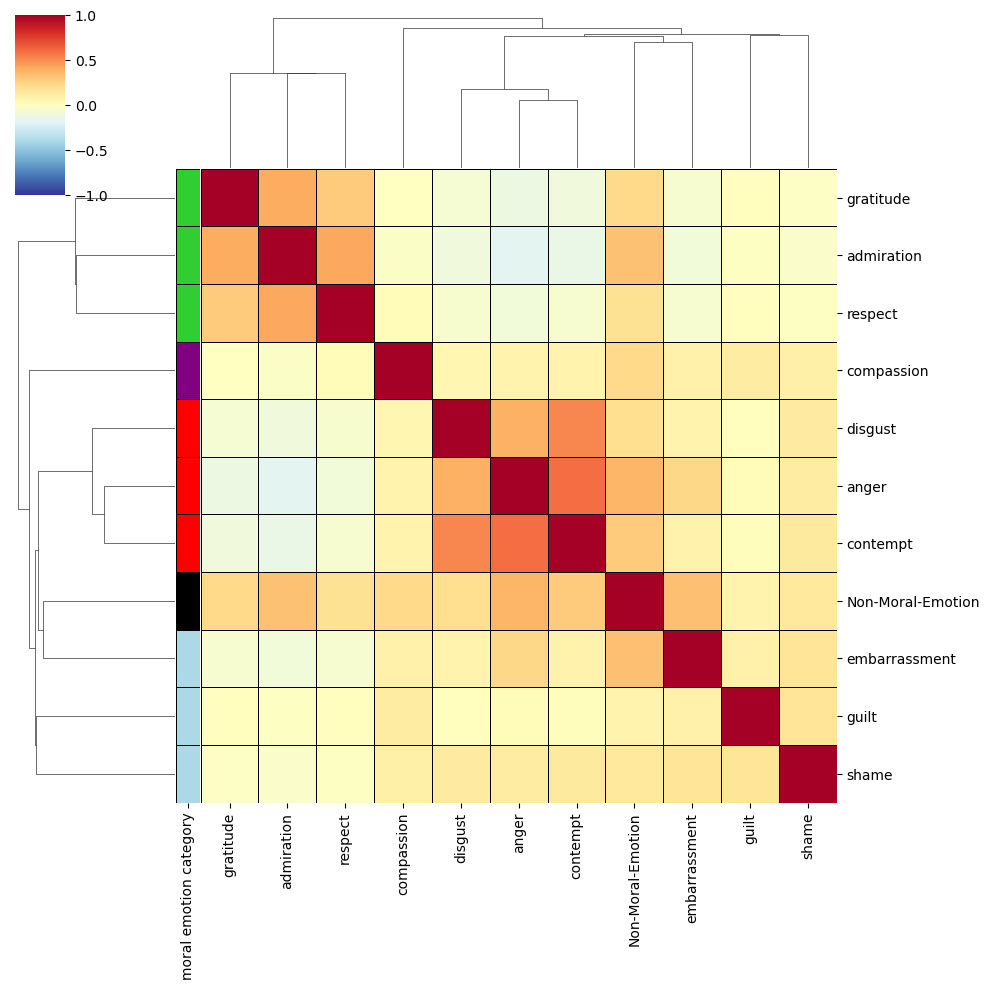

In [129]:
plt.figure(figsize=(100,100))
temp=sns.clustermap(corr,       
               cmap = 'RdYlBu_r',  
               metric="euclidean",
               method = 'single',
               vmin = -1, vmax = 1, 
               linewidths = 0.5, linecolor='black',
               xticklabels=True,
               yticklabels=True,
               row_colors=row_colors              
              )